<a href="https://colab.research.google.com/github/DavidPuigV/Nuclio/blob/main/cnn_dataaug_catsdogs_TrasferLearning_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Conectemonos a Google Drive y preparemos los datos

Los datos los podeis encontrar en esta URL de Google Drive
https://drive.google.com/open?id=1cCjzuanxmL15vz0xVt1BsFL1tBZZD0ox

Movedlos a vuestro Drive!!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

## 3. Definimos algunas constantes

In [3]:
ANCHO_IMAGEN=150
ALTURA_IMAGEN=150
IMAGE_SIZE=(ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES=3
ruta = '/content/drive/MyDrive/NUCLIO/Dogs-vs-cats/'

## 4. Preparamos los datos de entrenamiento

Los cargaremos del formato NPZ que comentamos en la última clase, y que tenemos en el Drive



In [4]:
dict_npz = np.load(ruta+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [5]:
print("Tamaño X train:", x_train_scaled.shape)
print("Tamaño Y train:", y_train_img.shape)

print("Tamaño X test:", x_test_scaled.shape)
print("Tamaño Y test:", y_test_img.shape)

print("Tamaño X val:", x_val_scaled.shape)
print("Tamaño Y val:", y_val_img.shape)



Tamaño X train: (2916, 150, 150, 3)
Tamaño Y train: (2916,)
Tamaño X test: (989, 150, 150, 3)
Tamaño Y test: (989,)
Tamaño X val: (988, 150, 150, 3)
Tamaño Y val: (988,)


## 5. Exploremos los datos

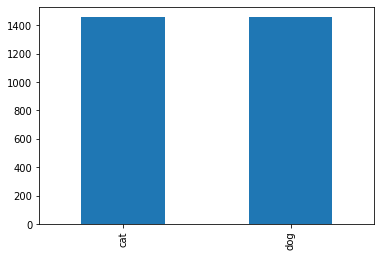

In [6]:
df_train = pd.DataFrame(y_train_img, columns=['category'])
df_train['category'].value_counts().plot.bar()

Como podemos ver tenemos 1458 ejemplos de cada clase... poquito para ser una red neuronal para vision por computador... ya vereis...

## 6. Pintemos una imagen

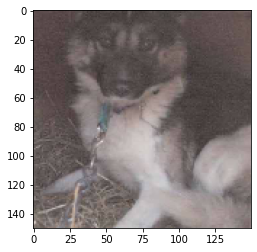

In [7]:
sample = random.choice(range(0,1457))
image = x_train_scaled[sample]
plt.imshow(image, cmap=plt.cm.binary)

## 7. Apilemos bloques para hacer el modelo

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

In [8]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

## 7.1 Vamos a cargar la parte de extraccion de features de vgg16

In [9]:
vgg = vgg16.VGG16(include_top=False, weights= 'imagenet', input_shape=(ANCHO_IMAGEN, ALTURA_IMAGEN, CANALES_IMAGENES))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [10]:
# necesito añadir el flatten despues de estas capas y despues procesar mis datos en mi red de clasificacion
# antes tengo que tener claro como va a ser la salida
# podemos acceder a las capas con el metodo layers, estan numeradas
# sacamos el objeto de definicion de mi output de mi ultima capa
def_output = vgg.layers[-1].output

# haremos el flatten layer, un modelo de unica capa.
new_flatten_layer = ks.layers.Flatten()(def_output)
# no puedo hacer summary porque flatten no es n modelo es solo una capa

In [11]:
# juntamos modelo de imagenet y nuestra capa flatten
# y ya tenemos la red para entrenar !!!!
vgg_model = Model(vgg.input, new_flatten_layer)
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [12]:
import pandas as pd

pd.set_option('max_colwidth', None)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['layer Type', 'Layer Name','Trainable?'])

,layer Type,Layer Name,Trainable?
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6de4e1be10>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6de4dfed30>,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6de4e54da0>,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6dd02c5dd8>,block1_pool,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02cda20>,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02c5a20>,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6dd02dd7f0>,block2_pool,True
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02e4748>,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02e44a8>,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02d56a0>,block3_conv3,True


In [13]:
# la red entera es entrenable???
print(vgg_model.trainable)   

True


In [14]:
# Queremos todo en entraenable False
vgg_model.trainable=False

for layer in vgg_model.layers:
  layer.trainable = False

In [15]:

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['layer Type', 'Layer Name','Trainable?'])

,layer Type,Layer Name,Trainable?
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6de4e1be10>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6de4dfed30>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6de4e54da0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6dd02c5dd8>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02cda20>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02c5a20>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6dd02dd7f0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02e4748>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02e44a8>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dd02d56a0>,block3_conv3,False


## 7.2 Pre-procesado hasta el cuello de botella

In [16]:
def llevar_cuello_botella(model, input_imgs):
  features = model.predict(input_imgs, verbose=0)
  return features
  

In [17]:
x_train_post_vgg = llevar_cuello_botella(vgg_model, x_train_scaled)
x_test_post_vgg = llevar_cuello_botella(vgg_model, x_test_scaled)
x_val_post_vgg = llevar_cuello_botella(vgg_model, x_val_scaled)

In [18]:
x_train_post_vgg.shape

(2916, 8192)

## 7.3 Montamos red de clasificacion

In [19]:
input_shape = vgg_model.output_shape[1]
print(input_shape)

8192


In [20]:
# ya sabemos el shape
# vamos a montar nuestra red de clasificacion de modo secuencial
model_post_vgg = ks.Sequential()

# metemos una mini capa que define el input layer
model_post_vgg.add(ks.layers.InputLayer(input_shape=(input_shape,)))

# aqui tambien ponemos la input_sahpe solo la primera capa
model_post_vgg.add(ks.layers.Dense(512, activation='relu',input_shape=(input_shape,)))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(1, activation='sigmoid')) # 1 de salida porque tenemos dos valores posibles 0 o 1 (tras aplicar un label encoder a dog y cat)

model_post_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


## 8. Montemos el optimizador compilando el modelo


In [30]:
model_post_vgg.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

## 9. Definamos un callback para el Early Stopping

**Early Stopping**

Prevenimos el sobre ajuste parando cuando tras 10 epochs y el error de la validacion no decrementa (estamos en una plateau)

In [31]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=5)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 10. Preparamos los datos

Haremos un one-hote encoding que nos va a ir bien para nuestra clasificación

In [32]:
y_train_img

array(['dog', 'cat', 'dog', ..., 'dog', 'dog', 'cat'], dtype='<U3')

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [34]:
y_train_encoded

array([1, 0, 1, ..., 1, 1, 0])

## 11. Transformador de imagenes a datos consumibles por la red neuronal

**De entrenamiento**

Aquí incluiremos nuestra parte de generación de imagenes (con código de partida)

In [35]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    )

train_generator = train_datagen.flow(
    x_train_img, 
    y_train_encoded, 
    batch_size=30
)

**De validacion y de testeo**

Fijaos que aquí la única modificación es un re-escalado, nada de modificaciones

In [36]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img, 
    y_val_encoded, 
    batch_size=20
)

test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow(
    x_test_img, 
    y_test_encoded,
    batch_size=20
)

No tiene mala pinta!!

## 12. Veamos que pinta tiene el generador de datos

A rellenar para ver que nos da el generadord de imagenes nuevas

## 13. Entrenemos el modelo!

In [37]:
epochs = 200

history = model_post_vgg.fit(x_train_post_vgg, y_train_encoded, epochs=epochs, validation_data=(x_val_post_vgg, y_val_encoded), batch_size=64, callbacks=[callback_val_loss, callback_val_accuracy])

Epoch 1/200
46/46 [==============================] - 1s 10ms/step - loss: 1.0910 - accuracy: 0.6090 - val_loss: 0.3006 - val_accuracy: 0.8755
Epoch 2/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2893 - accuracy: 0.8760 - val_loss: 0.2588 - val_accuracy: 0.8785
Epoch 3/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2242 - accuracy: 0.9088 - val_loss: 0.2433 - val_accuracy: 0.8887
Epoch 4/200
46/46 [==============================] - 0s 6ms/step - loss: 0.1684 - accuracy: 0.9233 - val_loss: 0.2716 - val_accuracy: 0.8897
Epoch 5/200
46/46 [==============================] - 0s 9ms/step - loss: 0.1330 - accuracy: 0.9504 - val_loss: 0.3850 - val_accuracy: 0.8745
Epoch 6/200
46/46 [==============================] - 0s 6ms/step - loss: 0.0933 - accuracy: 0.9685 - val_loss: 0.3398 - val_accuracy: 0.8856
Epoch 7/200
46/46 [==============================] - 0s 6ms/step - loss: 0.0763 - accuracy: 0.9699 - val_loss: 0.3697 - val_accuracy: 0.8887
Epoch 8/200


## 14. Guardemos el modelo

In [38]:
model_post_vgg.save(ruta+'model_with_TL_finetunning.h5')

## 15. Veamos los resultados

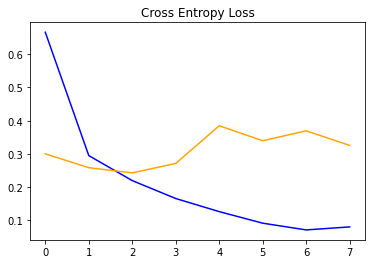

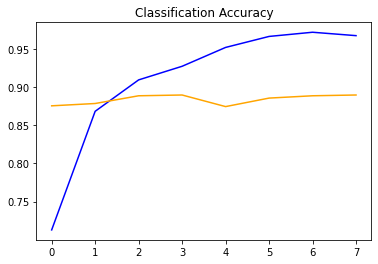

In [39]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [40]:
_, acc = model_post_vgg.evaluate(x_test_post_vgg, y_test_encoded, verbose=0)
print('Modelocon Batch Norlmalization n > %.3f' % (acc * 100.0))

Modelocon Batch Norlmalization n > 89.383
